In [1]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
# Unzipping the data
!unzip -q "archive.zip"

--2022-06-29 11:30:39--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2022-06-29 11:30:40--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7757d1e7f8bd521b1e10783333.dl.dropboxusercontent.com/cd/0/inline/BoHWqarclq9r0J67EPoqA6EatQ5977Zna7KQmh7_OSNEPpYVcYuubHbKL82_zs8b27IamXflfVbZove8-gL4UnI59dmzINsVWveb-9c_fQ1bnBY3qnJikaVFIH6R0U38oS4_1fMxinB2UcJyKMAdNMY0l4z0mZVNn2BQMgu1Ja05DQ/file# [following]
--2022-06-29 11:30:41--  https://uc7757d1e7f8bd521b1e10783333.dl.dropboxusercontent.com/cd/0/inline/BoHWqarclq9r0J67EPoqA6EatQ5977Zna7KQmh7_OSNEPpYVcYuubHbKL82_zs8b27Iam

In [2]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [3]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [4]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fb79ea974d0>


In [5]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0619-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0512-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/IM-0622-0001-0002.jpeg')]


In [6]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0619-0001.jpeg', 'chest_xray/train/NORMAL/IM-0512-0001.jpeg', 'chest_xray/train/NORMAL/IM-0622-0001-0002.jpeg']


In [7]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [8]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [9]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [10]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 704 ms, sys: 466 ms, total: 1.17 s
Wall time: 4.34 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


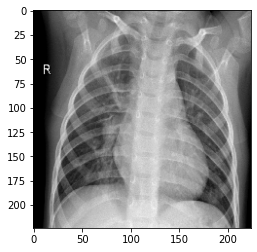

In [11]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [12]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 15.3 ms, sys: 1.1 ms, total: 16.5 ms
Wall time: 16.4 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


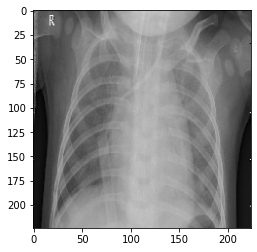

In [13]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [14]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [15]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [16]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [17]:
# Train the model
# a higher epochs nr. might improve results

history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9431 - precision: 0.9561 - recall: 0.9581
Epoch 1: val_loss improved from inf to 2.83720, saving model to best_weights.h5
163/163 [==============================] - 130s 561ms/step - loss: 0.1694 - accuracy: 0.9431 - precision: 0.9561 - recall: 0.9581 - val_loss: 2.8372 - val_accuracy: 0.4030 - val_precision: 1.0000 - val_recall: 0.0522
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9672 - precision: 0.9755 - recall: 0.9803
Epoch 2: val_loss improved from 2.83720 to 1.57147, saving model to best_weights.h5
163/163 [==============================] - 95s 586ms/step - loss: 0.0864 - accuracy: 0.9672 - precision: 0.9755 - recall: 0.9803 - val_loss: 1.5715 - val_accuracy: 0.6184 - val_precision: 0.6184 - val_recall: 1.0000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9666 - precision: 0.9773 - recall: 0.9778
Epoch 3

### Interpret the Results

The "history" variable contains the result of the training.

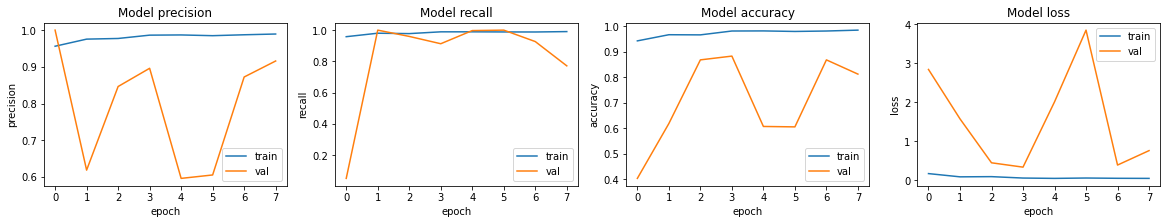

In [18]:
fix, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epoch')
  ax[i].set_ylabel(met)
  ax[i].legend(['train', 'val'])

### Formula for "recall" = true positive / (true positive + false negative)

### Accuracy keeps growing

### Recall gradually follows the training curve

### Loss increasing and not coming down means the model is overfitted.

In [20]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weights + architecture)
model.save("model.h5")

In [21]:
# Loading the whole model

loaded_model = tf.keras.models.load_model("model.h5")

# Evaluate Test Dataset

In [24]:
# Create Dataset Object for 'Testing' set just the way we did for the Training and Validation
# We don't do augmentation with test images!

test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x), test_image_paths))
test_labels = list(map(lambda x : get_label(x), test_image_paths))

test_image_path = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224, 224], method="nearest")
  return image, label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [17]:
# Verify Test Dataset Object

image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

PNEUMONIA


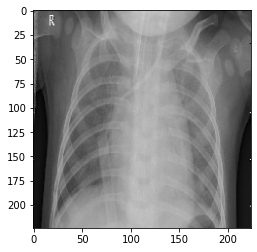

In [25]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [26]:
# Evaluate the loaded model.
# the evaluate methos takes in the data object as argument.
# the data object should not be infinitely iterated.

loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : ", acc)
print(" Testing Precision", prec)
print(" Testing Recall", rec)

1/1 [==============================] - 3s 3s/step - loss: 0.3588 - accuracy: 0.8125 - precision: 0.7778 - recall: 0.8750
 Testing Acc :  0.8125
 Testing Precision 0.7777777910232544
 Testing Recall 0.875
